# Imports

Imports all the necessary libraries.

In [1]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive')

import csv
import math
import networkx as nx
import numpy as np
import os
import seaborn as sns
import warnings

from matplotlib import pyplot as plt

os.chdir("drive/My Drive/M4R")
sns.set()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading Datasets

This function loads pre-selected datasets which we will attempt to use Newman's method on.

In [0]:
def load_data(dataset):

  """
  TODO: PLACEHOLDER DOCSTRING
  """

  data_matrix = []
  labels = []

  with open("gcn/data/{}/{}.content".format(dataset, dataset), 'r') as features:
    reader = csv.reader(features, delimiter='\t')
    for row in reader:
      temprow = row[1:-1]
      labels.append(row[-1])
      finalrow = [float(i) for i in temprow]
      data_matrix.append(finalrow)
  return data_matrix, labels

# Data Generation

The following functions create datasets so that we can investigate what sort of data Newman's method aids classification for.

In [0]:
def generate_constructive_data(N=1000, P=10, p_in=0.8, p_out=0.04, C=2, K=6):

  """
  Creates data according to a constructive block model as described in alignment
  paper.
  N: Number of individuals.
  P: Number of features.
  p_in: Probability that a feature is activated for a feature associated with
        that class.
  p_out: Probability that a feature is activated if not associated with the
         individual's class.
  C: Number of ground truth classes.
  K: Number of active features characterising each class.
  """

  # Initialise various required arrays
  feature_matrix = np.array([[0 for i in range(P)] for j in range(N)])
  possible_features = [i for i in range(P)]
  possible_classes = [i for i in range(C)]
  associated_features = []
  belonging = []

  # Randomly assign features to ground truth classes
  for block in range(C):
    block_features = np.random.choice(possible_features, size=K, replace=False)
    associated_features.append(block_features)
  associated_features = np.array(associated_features)

  # Randomly assign individuals to ground truth classes
  for individual in range(N):
    belonging.append(np.random.choice(possible_classes))
  
  # Create dataset according to these assignments and function arguments
  for individual in range(N):
    current_class = belonging[individual]
    current_features = associated_features[current_class]
    for feature in range(P):
      r = np.random.random()
      if feature in current_features:
        if r < p_in:
          feature_matrix[individual, feature] = 1
      else:
        if r < p_out:
          feature_matrix[individual, feature] = 1

  # Return feature matrix
  return feature_matrix

# Finding the prior edges

The next functions take a dataset, either discrete or continuous, and simulate "observing" an edge between individuals if their features are sufficiently similar.

In [0]:
def find_prior_edges_discrete(data):

  """
  Takes a dataset of N individuals with P features (each of which can take 
  discrete values), and returns an NxN similarity matrix, where element i, j of
  the matrix represents the number of features which are identical in individuals
  i and j.
  """

  # Initialise various arrays
  N = len(data)
  P = len(data[0])
  E_ij = [[0 for i in range(N)] for j in range(N)]

  # Set diagonal elements to the number of features
  for i in range(N):
    E_ij[i][i] = P

  # Find off-diagonal elements
  for individual in range(N-1):
    for other in range(individual+1, N):
      current = data[individual]
      comparison = data[other]
      for i in range(P):
        if current[i] == comparison[i]:
          E_ij[individual][other] += 1
          E_ij[other][individual] += 1

  # Return the similarity matrix
  return E_ij

In [0]:
# def find_prior_edges_continuous(data, threshold):

#   """
#   Takes a dataset of N individuals with P features (each of which can take 
#   any real value), and returns an NxN similarity matrix, where element i, j of
#   the matrix represents the number of features which are closer than a threshold
#   proportion of the range of values that feature takes.
#   """

#   # Initialise various structures
#   N = len(data)
#   P = len(data[0])
#   max_feature = [0 for i in range(P)]
#   min_feature = max_feature.copy()
#   feature_range = max_feature.copy()
#   feature_threshold = max_feature.copy()
#   E_ij = [[0 for i in range(N)] for j in range(N)]

#   # Find the maximum and minimum values that each feature takes
#   for f in range(P):
#     for i in range(N):
#       if i == 0:
#         f_max = data[i][f]
#         f_min = data[i][f]
#       else:
#         if data[i][f] > f_max:
#           f_max = data[i][f]
#         if data[i][f] < f_min:
#           f_min = data[i][f]
#     max_feature[f] = f_max
#     min_feature[f] = f_min

#   # Fin the threshold value for each feature
#   for f in range(P):
#     feature_range[f] = max_feature[f] - min_feature[f]
#     feature_threshold[f] = feature_range[f] * threshold
  
#   # Set diagonal elements to P
#   for i in range(N):
#     E_ij[i][i] = P

#   # Calculate off-diagonal elements
#   for individual in range(N-1):
#     for other in range(individual+1, N):
#       current = data[individual]
#       comparison = data[other]
#       for i in range(P):
#         if abs(current[i] - comparison[i]) < feature_threshold[i]:
#           E_ij[individual][other] += 1
#           E_ij[other][individual] += 1

#   # Return similarity matrix
#   return E_ij

def find_prior_edges_continuous(data, threshold):

  N, P = data.shape

  maxs = np.max(data, axis=0)
  mins = np.min(data, axis=0)
  ranges = (maxs-mins) * threshold

  Q_ij = np.zeros((N, N))

  for i in range(N):
    Q_ij[i][i] = P

  for i in range(N-1):
    for j in range(i+1, N):
      temp = np.abs(data[i,:] - data[j,:]) < ranges
      number = np.sum(temp)
      Q_ij[i][j] = number
      Q_ij[j][i] = number
  
  return Q_ij

# Finding the posterior edges

The following functions iterate Newman's model to convergence, and then generate a graph from the posterior probabilities of an edge's existence. We can do this with uniform values of $\alpha$ and $\beta$ across the network, or with individualised values of the parameters.

In [0]:
# def find_posterior_edges_uniform(E_ij, P, alpha_init, beta_init, rho_init, tolerance):

#   """
#   Iterates Newman's model on prior edge observations to find posterior estimates
#   for the probability of edges between each individual, in the case where there
#   is one value of alpha and one value of beta for the entire network.
  
#   TODO: Create some sort of warning system for large N or small values of E_ij
#         relative to N.
#   """
  
#   # Initialise some variables
#   N = len(E_ij)
#   Q_ij = [[0 for i in range(N)] for i in range(N)]
#   alpha = 0 + alpha_init
#   beta = 0 + beta_init
#   rho = 0 + rho_init

#   # Collect alpha, beta and rho over time to monitor speed of convergence
#   alphas = [alpha]
#   betas = [beta]
#   rhos = [rho]

#   # Find initial values of Q_ij
#   for i in range(N-1):
#     for j in range(i+1, N):
#       temp = np.log(1 - rho) + (E_ij[i][j] * np.log(beta)) + ((P - E_ij[i][j]) \
#              * np.log(1 - beta)) - np.log(rho) - (E_ij[i][j] * np.log(alpha)) \
#              - ((P - E_ij[i][j]) * np.log(1 - alpha))
#       final_value = 1 / (1 + np.exp(temp))
#       Q_ij[i][j] = final_value
#       Q_ij[j][i] = final_value

#   # Iterate the equations to convergence
#   while True:

#     # Store the old values of alpha, beta and rho
#     alpha_old = 0 + alpha
#     beta_old = 0 + beta
#     rho_old = 0 + rho
#     alpha_num = 0
#     alpha_denom = 0
#     beta_num = 0
#     beta_denom = 0
#     rho = 0

#     # Calculate new values of alpha, beta and rho
#     for i in range(N):
#       for j in range(i):
#         rho += Q_ij[i][j]
#         alpha_num += E_ij[i][j] * Q_ij[i][j]
#         alpha_denom += P * Q_ij[i][j]
#         beta_num += E_ij[i][j] * (1 - Q_ij[i][j])
#         beta_denom += P * (1 - Q_ij[i][j])

#     alpha = alpha_num / alpha_denom
#     beta = beta_num / beta_denom
#     rho = rho / (math.factorial(N) / (math.factorial(2) * math.factorial(N-2)))

#     # Find the difference between alpha, beta and rho and their old values
#     alpha_diff = abs(alpha - alpha_old)
#     beta_diff = abs(beta - beta_old)
#     rho_diff = abs(rho - rho_old)
#     alphas.append(alpha)
#     betas.append(beta)
#     rhos.append(rho)

#     # Break the loop if all differences fall below our tolerance
#     if alpha_diff < tolerance and beta_diff < tolerance and rho_diff < tolerance:
#       break

#     # Update Q_ij
#     for i in range(N-1):
#       for j in range(i+1, N):
#         temp = np.log(1 - rho) + (E_ij[i][j] * np.log(beta)) + ((P - E_ij[i][j]) \
#                * np.log(1 - beta)) - np.log(rho) - (E_ij[i][j] * np.log(alpha)) \
#                - ((P - E_ij[i][j]) * np.log(1 - alpha))
#         final_value = 1 / (1 + np.exp(temp))
#         Q_ij[i][j] = final_value
#         Q_ij[j][i] = final_value
    
#   # Return our posterior edges and the final values of alpha, beta and rho
#   return Q_ij, alphas, betas, rhos

def find_posterior_edges_uniform(E_ij, P, alpha_init, beta_init, rho_init, tolerance):

  """
  Iterates Newman's model on prior edge observations to find posterior estimates
  for the probability of edges between each individual, in the case where there
  is one value of alpha and one value of beta for the entire network.
  
  TODO: Create some sort of warning system for large N or small values of E_ij
        relative to N.
  """
  
  # Initialise some variables
  N = len(E_ij)
  Q_ij = np.zeros((N, N))
  alpha = 0 + alpha_init
  beta = 0 + beta_init
  rho = 0 + rho_init

  # Collect alpha, beta and rho over time to monitor speed of convergence
  alphas = [alpha]
  betas = [beta]
  rhos = [rho]

  temp = np.log(1 - rho) + (E_ij * np.log(beta)) + ((P - E_ij) \
             * np.log(1 - beta)) - np.log(rho) - (E_ij * np.log(alpha)) \
             - ((P - E_ij) * np.log(1 - alpha))

  Q_ij = 1 / (1 + np.exp(temp))

  # Iterate the equations to convergence
  while True:

    # Store the old values of alpha, beta and rho
    alpha_old = 0 + alpha
    beta_old = 0 + beta
    rho_old = 0 + rho
    alpha_num = 0
    alpha_denom = 0
    beta_num = 0
    beta_denom = 0
    rho = 0

    # Calculate new values of alpha, beta and rho

    rho = (Q_ij.sum() - np.trace(Q_ij)) / 2
    EQ = E_ij * Q_ij
    EOMQ = E_ij * (1 - Q_ij)
    alpha_num = (EQ.sum() - np.trace(EQ)) / 2
    beta_num = (EOMQ.sum() - np.trace(EOMQ)) / 2
    alpha_denom = P * rho
    beta_denom = P * ((((N ** 2) - N) / 2) - rho)

    alpha = alpha_num / alpha_denom
    beta = beta_num / beta_denom
    rho = rho / (math.factorial(N) / (math.factorial(2) * math.factorial(N-2)))

    # Find the difference between alpha, beta and rho and their old values
    alpha_diff = abs(alpha - alpha_old)
    beta_diff = abs(beta - beta_old)
    rho_diff = abs(rho - rho_old)
    alphas.append(alpha)
    betas.append(beta)
    rhos.append(rho)

    # Break the loop if all differences fall below our tolerance
    if alpha_diff < tolerance and beta_diff < tolerance and rho_diff < tolerance:
      break

    # Update Q_ij
    temp = np.log(1 - rho) + (E_ij * np.log(beta)) + ((P - E_ij) \
             * np.log(1 - beta)) - np.log(rho) - (E_ij * np.log(alpha)) \
             - ((P - E_ij) * np.log(1 - alpha))

    Q_ij = 1 / (1 + np.exp(temp))
    
  # Return our posterior edges and the final values of alpha, beta and rho
  return Q_ij, alphas, betas, rhos

In [0]:
def generate_graph(Q_ij, threshold):

  """
  Generates an adjacency matrix based on posterior estimates of the probability
  of an edge existing. "Activates" the edge if the probability of it existing
  exceeds a threshold value.
  """

  # Initialise empty adjacency matrix
  N = len(Q_ij)
  adj = [[0 for i in range(N)] for j in range(N)]

  # Check if each pair is connected
  for i in range(N-1):
    for j in range(i+1, N):
      if i != j and Q_ij[i][j] > threshold:
        adj[i][j] = 1
        adj[j][i] = 1
  
  # Return adjacency matrix
  return np.array(adj)

# def generate_graph2(Q_ij, threshold):

#   """
#   Generates an adjacency matrix based on posterior estimates of the probability
#   of an edge existing. "Activates" the edge if the probability of it existing
#   exceeds a threshold value.
#   """

#   # Initialise empty adjacency matrix
#   N = len(Q_ij)
  
#   adj = Q_ij > threshold
#   adj = 1*adj

#   for i in range(N):
#     adj[i][i] = 0

#   return adj

# Pipeline

This knits all of the above functions together.

In [0]:
def graph_from_data(dataset, discrete=False, plot=False, convergence_tolerance=0.01, graph_threshold = 0.2, graph=True, cts_prior_threshold=0.1):

  """
  From a feature matrix, creates prior edges, iterates Newman's equations to
  get posterior edge probabilities, and generates a networkx graph of these.
  Also plots alpha, beta and rho across iterations and draws the graph obtained
  from the data.
  """
  
  # Generate prior edge observations
  if discrete:
    prior_edges = find_prior_edges_discrete(dataset)
  else:
    prior_edges = find_prior_edges_continuous(dataset, threshold=cts_prior_threshold)

  # Iterate Newman's equations and create a graph
  P = len(dataset[0])
  posterior_edges, alphas, betas, rhos = find_posterior_edges_uniform(prior_edges, P, 0.7, 0.3, 0.5, convergence_tolerance)
  if graph:
    adjacency_matrix = generate_graph(posterior_edges, graph_threshold)

  # Plot alpha, beta and rho
  if plot:

    plt.figure(figsize=(12, 8))
    plt.plot(alphas)
    plt.title("convergence of alpha")
    plt.xlabel("iteration")
    plt.ylabel("alpha")

    plt.figure(figsize=(12, 8))
    plt.plot(betas)
    plt.title("convergence of alpha")
    plt.xlabel("iteration")
    plt.ylabel("beta")

    plt.figure(figsize=(12, 8))
    plt.plot(rhos)
    plt.title("convergence of alpha")
    plt.xlabel("iteration")
    plt.ylabel("rho")

    if graph:
      # Draw the network
      plt.figure(figsize=(12, 8))
      graph = nx.from_numpy_matrix(adjacency_matrix)
      nx.draw(graph, node_size=20)

  # Return the graph
  if graph:
    return adjacency_matrix
  else:
    return posterior_edges

# Loading existing datasets and looking at their dimensionalities

Loading up the datasets provided and inspecting them.

'aminer', 'constructive', 'cora' and 'digits are discrete.

'cell', 'fma' and 'segmentation' are continuous.

The pipeline works on 'cell', 'digits', 'fma' and 'segmentation', but not on 'aminer', 'constructive' or 'cora'. Why? Certainly a correlation with the number of features, but sparsity must also be involved or it wouldn't work on 'cell'.

In [0]:
aminer_dataset, aminer_labels = load_data('aminer')
cell_dataset, cell_labels = load_data('cell')
constructive_dataset, constructive_labels = load_data('constructive')
cora_dataset, cora_labels = load_data('cora')
digits_dataset, digits_labels = load_data('digits')
fma_dataset, fma_labels = load_data('fma')
segmentation_dataset, segmentation_labels = load_data('segmentation')

In [10]:
datasets = {'aminer': aminer_dataset,
            'cell': cell_dataset,
            'constructive': constructive_dataset,
            'cora': cora_dataset,
            'digits': digits_dataset,
            'fma': fma_dataset,
            'segmentation': segmentation_dataset
}

for d_name in datasets.keys():
  N = len(datasets[d_name])
  P = len(datasets[d_name][0])
  print("{} dataset has {} individuals and {} features".format(d_name, N, P))

aminer dataset has 2072 individuals and 500 features
cell dataset has 2000 individuals and 500 features
constructive dataset has 1000 individuals and 500 features
cora dataset has 2485 individuals and 1433 features
digits dataset has 1797 individuals and 64 features
fma dataset has 2000 individuals and 140 features
segmentation dataset has 2310 individuals and 19 features


# Obtaining Graphs

Get Q_ij and then get a range of different graphs from it. THESE HAVE BEEN GENERATED.

In [0]:
# print("Finding Q_ij for digits dataset")
# print()
# digits_Q = graph_from_data(digits_dataset, discrete=True, graph=False)

# cell_Qs = []
# fma_Qs = []
# segmentation_Qs = []

# posterior_thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]

# for thr in posterior_thresholds:
#   print("Finding Q_ij for cell dataset with threshold {}".format(thr))
#   cell_Qs.append(graph_from_data(cell_dataset, cts_prior_threshold=thr, graph=False))
#   print("Finding Q_ij for fma dataset with threshold {}".format(thr))
#   fma_Qs.append(graph_from_data(fma_dataset, cts_prior_threshold=thr, graph=False))
#   print("Finding Q_ij for segmentation dataset with threshold {}".format(thr))
#   segmentation_Qs.append(graph_from_data(segmentation_dataset, cts_prior_threshold=thr, graph=False))
#   print()

# print("Done!")

In [0]:
# with open("digits_Q.csv", 'w') as f_in:
#   writer = csv.writer(f_in)
#   for row in digits_Q:
#     writer.writerow(row)

# i = 0
# for thr in posterior_thresholds:
#   with open("cell_Q_{}.csv".format(thr), 'w') as f_in:
#     writer = csv.writer(f_in)
#     for row in cell_Qs[i]:
#       writer.writerow(row)
#   with open("fma_Q_{}.csv".format(thr), 'w') as f_in:
#     writer = csv.writer(f_in)
#     for row in fma_Qs[i]:
#       writer.writerow(row)
#   with open("segmentation_Q_{}.csv".format(thr), 'w') as f_in:
#     writer = csv.writer(f_in)
#     for row in segmentation_Qs[i]:
#       writer.writerow(row)

# print("Posterior graph estimates written to drive")

# Loading the Generated Graphs

Does what it says on the tin.

In [0]:
def load_adjacency_matrix(dataset, threshold=None):

  """
  PLACEHOLDER DOCSTRING TODO
  """

  if dataset == 'digits':
    filename = 'digits_Q.csv'
  elif dataset in ['cell', 'fma', 'segmentation']:
    filename = '{}_Q_{}.csv'.format(dataset, threshold)
  else:
    print('Dataset adjacency matrix does not exist')
    return None

  adjacency_matrix = []

  filename = 'graphs/{}/'.format(dataset) + filename
  
  with open(filename, 'r') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
      adjacency_matrix.append(row)
  
  return np.array(adjacency_matrix)

# Getting a GCN doing Classification

In [0]:
for name in list(FLAGS):
  delattr(FLAGS, name)

NameError: ignored

In [0]:
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
tf.disable_eager_execution()

from sklearn.decomposition import PCA

tf.app.flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
tf.app.flags.DEFINE_integer('epochs', 2000, 'Number of epochs to train.')
tf.app.flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
tf.app.flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
tf.app.flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
tf.app.flags.DEFINE_integer('early_stopping', 200, 'Tolerance for early stopping (# of epochs).')
tf.app.flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
tf.app.flags.DEFINE_string('case', 'knn', 'Case string.')
tf.app.flags.DEFINE_string('f', '', 'kernel')

FLAGS = tf.app.flags.FLAGS

from gcn.utils import *
from gcn.models import GCN, MLP

# from sklearn.neighbors import kneighbors_graph
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy.io

In [0]:
import time

In [0]:
def run_gcn(dataset_name, features, y, adj=None, model="gcn"):

  features = csr_matrix(features, dtype=np.float32)
  features = features.tolil()
  y = encode_onehot(y)

  dropout=0.5
  epochs=2000
  early_stopping=200

  # Set random seed
  seed = 123
  np.random.seed(seed)
  tf.set_random_seed(seed)

  # Load data
  y_train, y_val, y_test, train_mask, val_mask, test_mask, idx_train, idx_val, idx_test = get_splits(y, dataset=dataset_name)

  # Some preprocessing
  features = preprocess_features(features)
  if model == 'gcn':
      support = [preprocess_adj(adj)]
      num_supports = 1
      model_func = GCN
  elif model == 'mlp':
      support = [preprocess_adj(adj)]  # Not used
      num_supports = 1
      model_func = MLP
  else:
      raise ValueError('Invalid argument for model: ' + str(model))

  # Define placeholders
  placeholders = {
      'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
      'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
      'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
      'labels_mask': tf.placeholder(tf.int32),
      'dropout': tf.placeholder_with_default(0., shape=()),
      'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
  }

  # Create model
  model = model_func(placeholders, input_dim=features[2][1], logging=True)

  # Initialize session
  sess = tf.Session()


  # Define model evaluation function
  def evaluate(features, support, labels, mask, placeholders):
      t_test = time.time()
      feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
      outs_val = sess.run([model.loss, model.accuracy, model.outputs, model.outputs], feed_dict=feed_dict_val)
      return outs_val[0], outs_val[1], outs_val[2], (time.time() - t_test)


  # Init variables
  sess.run(tf.global_variables_initializer())

  cost_val = []

  # Train model
  for epoch in range(epochs):

      t = time.time()
      # Construct feed dictionary
      feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
      feed_dict.update({placeholders['dropout']: dropout})

      # Training step
      outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

      # Validation
      cost, acc, outputs, duration = evaluate(features, support, y_val, val_mask, placeholders)
      cost_val.append(cost)

      # Print results
      # print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
      #       "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
      #       "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

      if epoch > early_stopping and cost_val[-1] > np.mean(cost_val[-(early_stopping+1):-1]):
          # print("Early stopping...")
          break

  # print("Optimization Finished!")

  # Testing
  test_cost, test_acc, test_outputs, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
  # print("Test set results:", "cost=", "{:.5f}".format(test_cost),
        # "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))
  
  return test_acc

# PCA - Working out Breakdown Point

In [17]:
constructive_dataset = np.array(constructive_dataset)
print(constructive_dataset.shape)

(1000, 500)


In [18]:
pca = PCA(n_components=500)
pca.fit(constructive_dataset)
new_constructive = pca.transform(constructive_dataset)
E_cons = np.array(find_prior_edges_discrete(constructive_dataset))
print(np.unique(E_cons))

[469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486
 487 488 489 490 491 492 493 494 495 496 497 498 499 500]


In [19]:
E_cons_PCA = np.array(find_prior_edges_continuous(new_constructive, 0.1))
print(np.unique(E_cons_PCA))

[137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.
 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164.
 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178.
 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192.
 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206.
 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220.
 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232. 233. 234.
 235. 236. 237. 238. 239. 240. 241. 242. 243. 244. 245. 246. 247. 248.
 249. 250. 251. 252. 253. 254. 255. 256. 257. 258. 259. 260. 261. 262.
 263. 264. 265. 266. 267. 268. 269. 270. 271. 272. 273. 274. 275. 276.
 277. 278. 279. 280. 281. 282. 283. 284. 285. 286. 287. 288. 289. 290.
 291. 292. 293. 294. 295. 296. 297. 298. 299. 300. 301. 302. 303. 304.
 305. 306. 307. 308. 309. 310. 311. 312. 313. 314. 315. 316. 317. 318.
 319. 320. 321. 322. 323. 324. 325. 326. 327. 328. 329. 330. 331. 332.
 333. 

In [20]:
dimensionalities = [2, 10, 50, 100, 250, 500]

for dim in dimensionalities:
  print("Attempting Newman's method with {} dimensions on constructive".format(dim))
  t1 = time.time()
  pca = PCA(n_components=dim)
  pca.fit(constructive_dataset)
  reduced_constructive = pca.transform(constructive_dataset)
  g = graph_from_data(reduced_constructive, graph=False)
  print(np.min(g))
  t2 = time.time()
  print("Successful! Completed in {} seconds".format(t2-t1))

Attempting Newman's method with 2 dimensions on constructive
0.2351388007162225
Successful! Completed in 4.675165891647339 seconds
Attempting Newman's method with 10 dimensions on constructive
0.0037062371288455985
Successful! Completed in 4.597942113876343 seconds
Attempting Newman's method with 50 dimensions on constructive
5.235022698359777e-09
Successful! Completed in 4.95542049407959 seconds
Attempting Newman's method with 100 dimensions on constructive
6.32840038776114e-12
Successful! Completed in 4.856519937515259 seconds
Attempting Newman's method with 250 dimensions on constructive
9.682116622031535e-15
Successful! Completed in 5.441341400146484 seconds
Attempting Newman's method with 500 dimensions on constructive
2.0529440692394606e-13
Successful! Completed in 5.911975860595703 seconds


In [21]:
para = [((i+1)/100) for i in range(20)]

accs = []

for p in para:
  print("running with parameter {}".format(p))
  adjacency = load_adjacency_matrix('fma', threshold = p)
  g = generate_graph(adjacency, 0.9)
  accs.append(run_gcn('fma', fma_dataset, fma_labels, adj=g, model='gcn'))

running with parameter 0.01
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

running with parameter 0.02
running with parameter 0.03
running with parameter 0.04
running with parameter 0.05
running with parameter 0.06
running with parameter 0.07
running with parameter 0.08
running with parameter 0.09
running with parameter 0.1
running with parameter 0.11
running with parameter 0.12
running with parameter 0.13
running with parameter 0.14
running with parameter 0.15
running with parameter 0.16
running with parameter 0.17
running with parameter 0.18
running with parameter 0.19
running with parameter 0.2


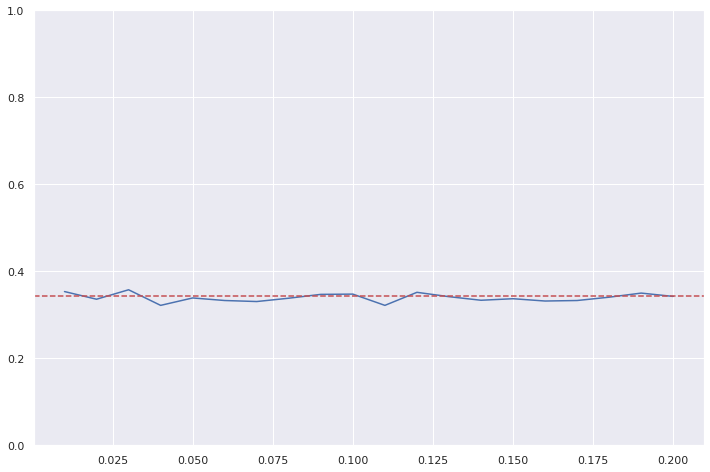

In [22]:
plt.figure(figsize=(12,8))
plt.ylim((0, 1))
plt.plot(para, accs)
plt.axhline(0.343, color='r', linestyle='--')

In [23]:
ad = generate_graph(g, 0.9999999)
print("generated")
acc = run_gcn('constructive', constructive_dataset, constructive_labels, adj=ad, model='mlp')
print("MLP accuracy is {}%".format(100*acc))

generated
MLP accuracy is 41.411763429641724%


In [0]:
thresholds = [-(i+1) for i in range(16)]

accs = []

for thr in thresholds:
  t1 = time.time()
  ad = generate_graph(g, 1-(10 ** thr))
  print("generated graph with threshold {}".format(thr))
  acc = run_gcn('constructive', constructive_dataset, constructive_labels, adj=ad, model='gcn')
  print("GCN accuracy with graph is {}%".format(100*acc))
  t2 = time.time()
  print("time taken: {} seconds".format(t2-t1))
  print()

generated graph with threshold -1
Early stopping...
Optimization Finished!
Test set results: cost= 1.98868 accuracy= 0.42118 time= 0.00309
GCN accuracy with graph is 42.11764633655548%
time taken: 4.040947437286377 seconds

generated graph with threshold -2
Early stopping...
Optimization Finished!
Test set results: cost= 2.03040 accuracy= 0.42118 time= 0.00283
GCN accuracy with graph is 42.11764633655548%
time taken: 3.585967540740967 seconds

generated graph with threshold -3
Early stopping...
Optimization Finished!
Test set results: cost= 1.95691 accuracy= 0.41529 time= 0.00267
GCN accuracy with graph is 41.52941107749939%
time taken: 4.6850714683532715 seconds

generated graph with threshold -4
Early stopping...
Optimization Finished!
Test set results: cost= 1.95830 accuracy= 0.42706 time= 0.00254
GCN accuracy with graph is 42.70587861537933%
time taken: 4.521976470947266 seconds

generated graph with threshold -5
Early stopping...
Optimization Finished!
Test set results: cost= 1.99

# Cross-Validation and Plots

KeyboardInterrupt: ignored

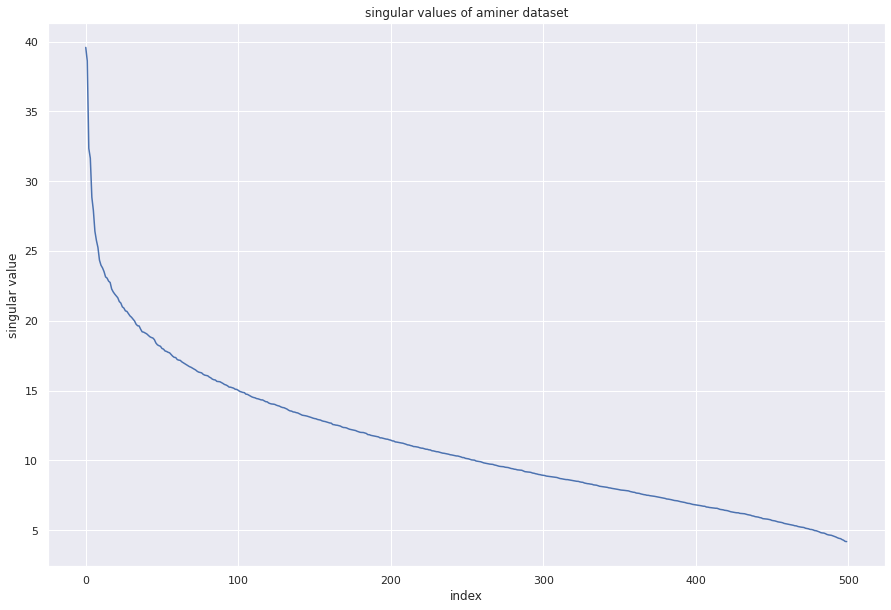

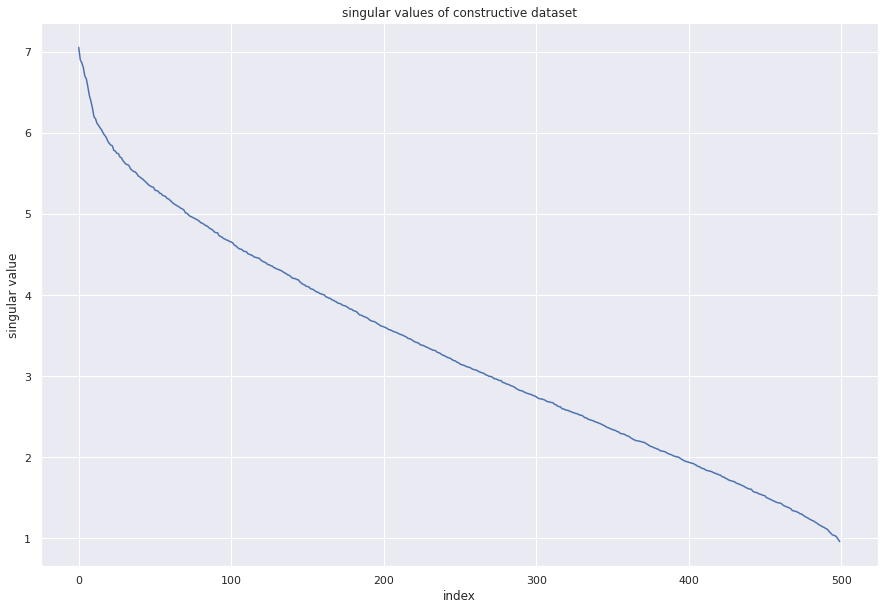

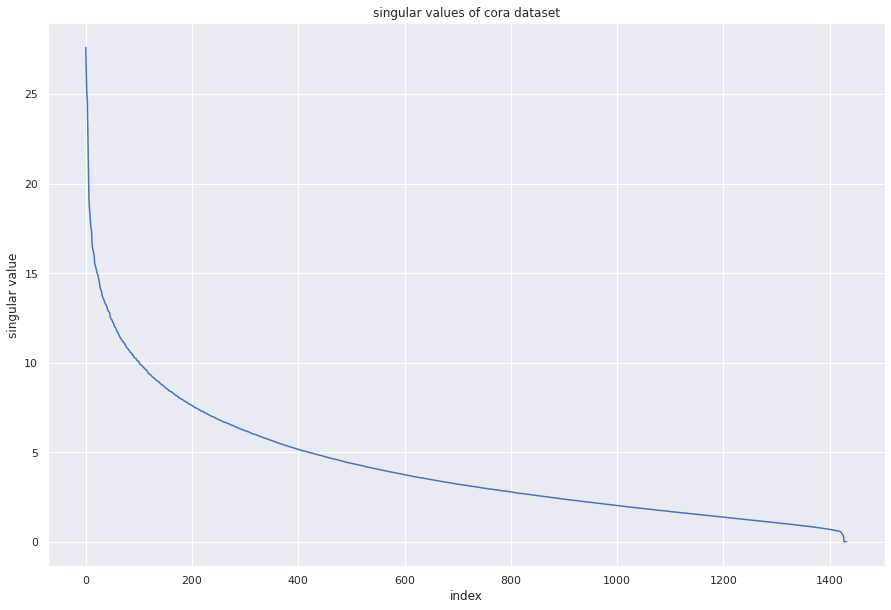

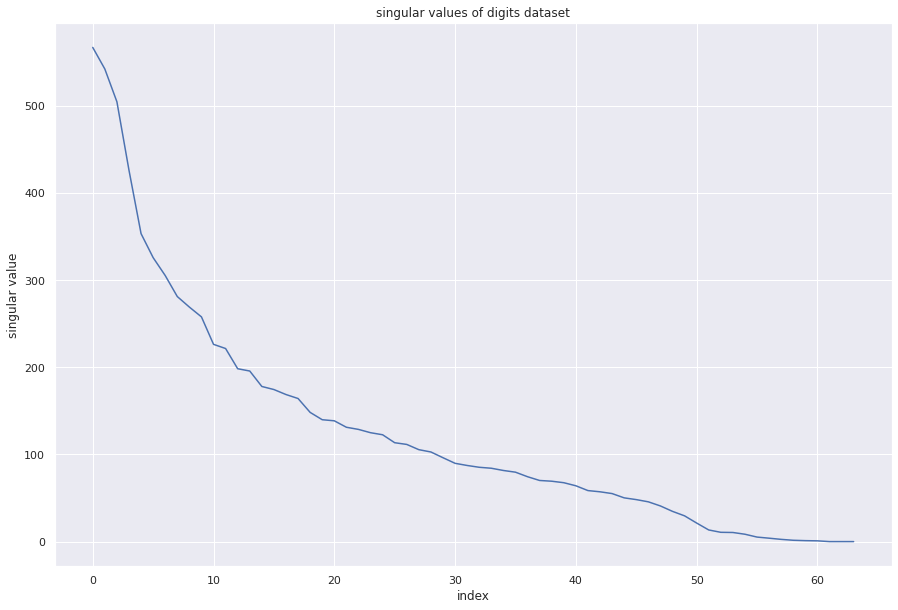

In [0]:
dataset_features = {
    'aminer': 500,
    'cell': 500,
    'constructive': 500,
    'cora': 1433,
    'digits': 64,
    'fma': 140,
    'segmentation': 19
}

discrete_datasets = {'aminer': aminer_dataset,
                     'constructive': constructive_dataset,
                     'cora': cora_dataset,
                     'digits': digits_dataset
}

dataset_evals = {}

for dataset in discrete_datasets.keys():
  dim = dataset_features[dataset]
  pca = PCA(n_components=dim)
  pca.fit(discrete_datasets[dataset])
  dataset_evals[dataset] = pca.singular_values_
  plt.figure(figsize=(15, 10))
  plt.plot(dataset_evals[dataset])
  plt.title('singular values of {} dataset'.format(dataset))
  plt.xlabel('index')
  plt.ylabel('singular value')
  plt.savefig('plots/pca/{}_singular_values'.format(dataset))

In [0]:
final_datasets = {}

final_datasets['cell'] = np.array(cell_dataset)
final_datasets['fma'] = np.array(fma_dataset)
final_datasets['segmentation'] = np.array(segmentation_dataset)

dataset_features = {
    'aminer': 500,
    'cell': 500,
    'constructive': 500,
    'cora': 1433,
    'digits': 64,
    'fma': 140,
    'segmentation': 19
}

discrete_datasets = {'aminer': aminer_dataset,
                     'constructive': constructive_dataset,
                     'cora': cora_dataset,
                     'digits': digits_dataset
}

for dataset in discrete_datasets.keys():
  original_dataset = discrete_datasets[dataset]
  dim = len(original_dataset[0])
  pca = PCA(n_components=dim)
  pca.fit(original_dataset)
  transformed_dataset = pca.transform(original_dataset)
  final_datasets[dataset] = transformed_dataset

In [0]:
def measure_accuracy(name, dataset, y, adj, model='gcn', num_repeats=5, verbose=False):
  
  accuracy_measurements = []

  for i in range(num_repeats):
    t1 = time.time()
    acc = run_gcn(name, dataset, y, adj, model='gcn')
    t2 = time.time()
    if verbose:
      print("iteration took {} seconds".format(t2-t1))
    accuracy_measurements.append(acc)
  
  mean = np.mean(accuracy_measurements)

  return mean

dataset cell, threshold 1e-05
dataset cell, threshold 3.1622776601683795e-05
dataset cell, threshold 0.0001
dataset cell, threshold 0.00031622776601683794
dataset cell, threshold 0.001
dataset cell, threshold 0.0031622776601683794
dataset cell, threshold 0.01
dataset cell, threshold 0.03162277660168379
dataset cell, threshold 0.1
dataset cell, threshold 0.31622776601683794
dataset cell, threshold 1.0
dataset fma, threshold 1e-05
dataset fma, threshold 3.1622776601683795e-05
dataset fma, threshold 0.0001
dataset fma, threshold 0.00031622776601683794
dataset fma, threshold 0.001
dataset fma, threshold 0.0031622776601683794
dataset fma, threshold 0.01
dataset fma, threshold 0.03162277660168379
dataset fma, threshold 0.1
dataset fma, threshold 0.31622776601683794
dataset fma, threshold 1.0
dataset segmentation, threshold 1e-05
dataset segmentation, threshold 3.1622776601683795e-05
dataset segmentation, threshold 0.0001
dataset segmentation, threshold 0.00031622776601683794
dataset segmenta

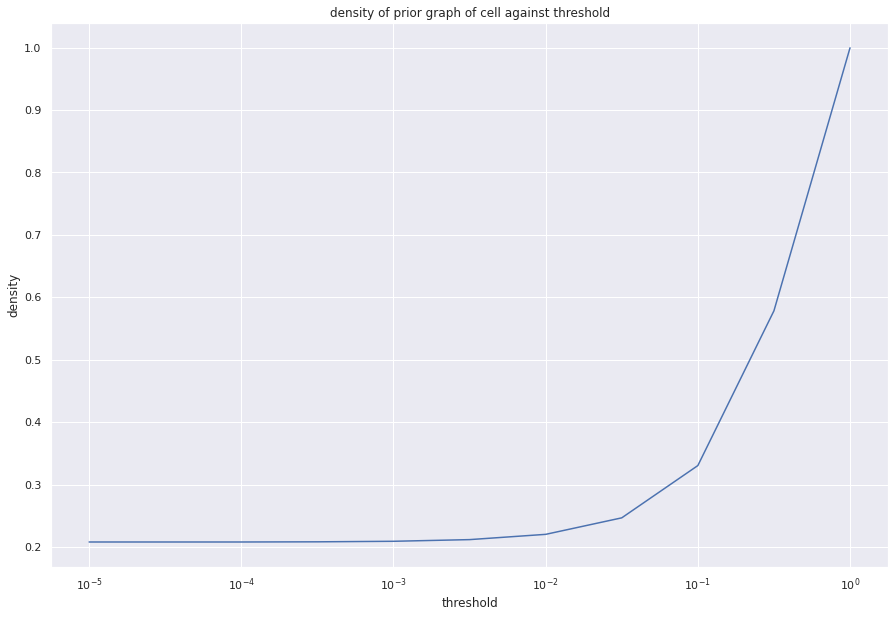

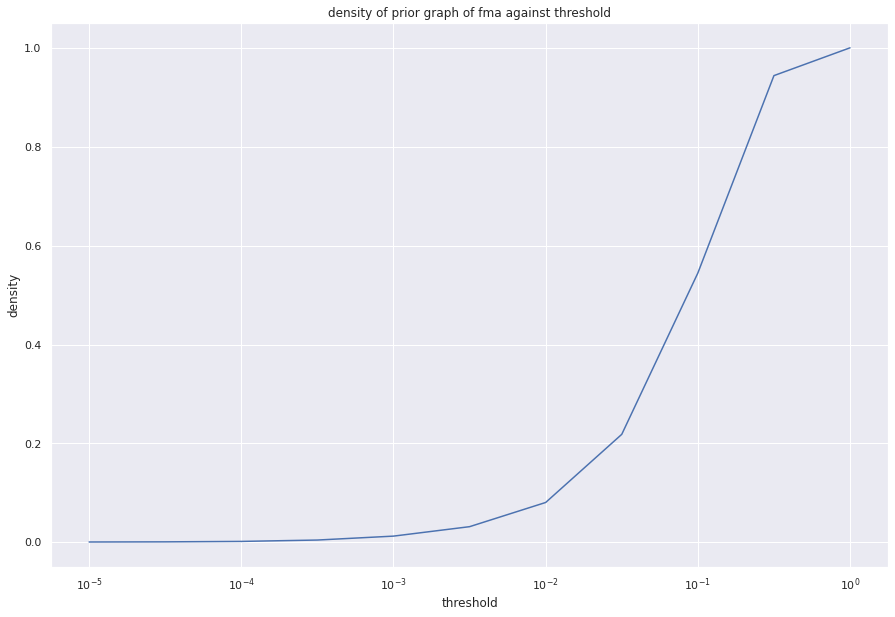

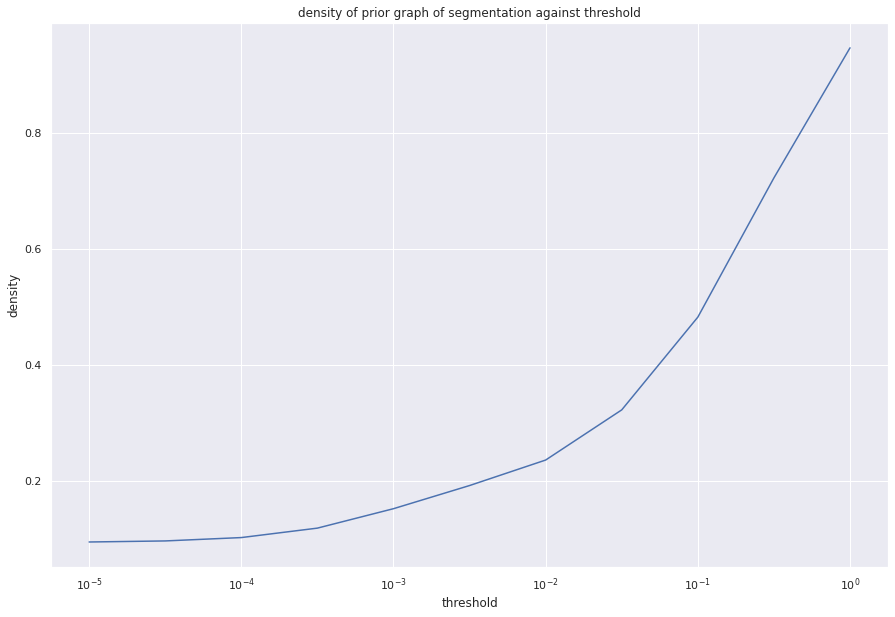

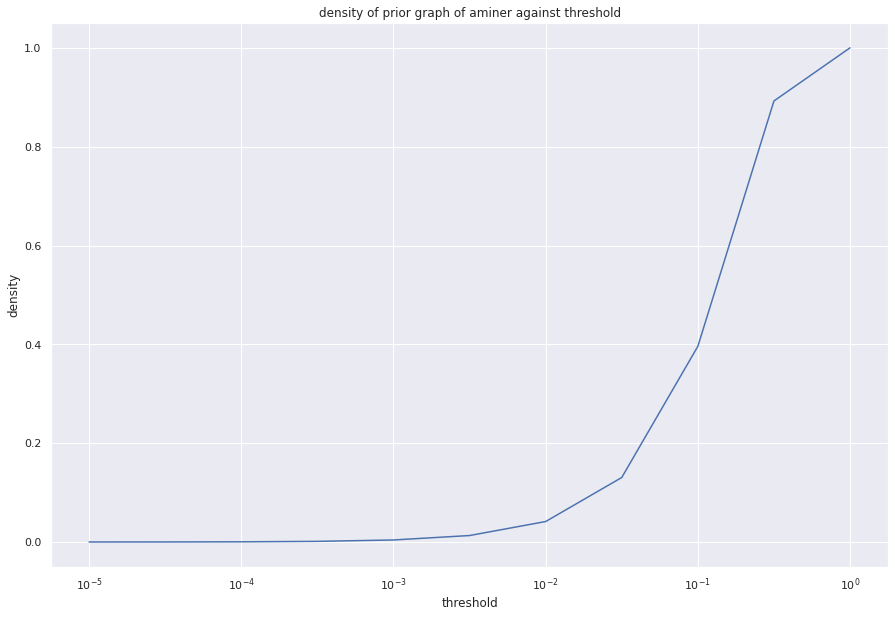

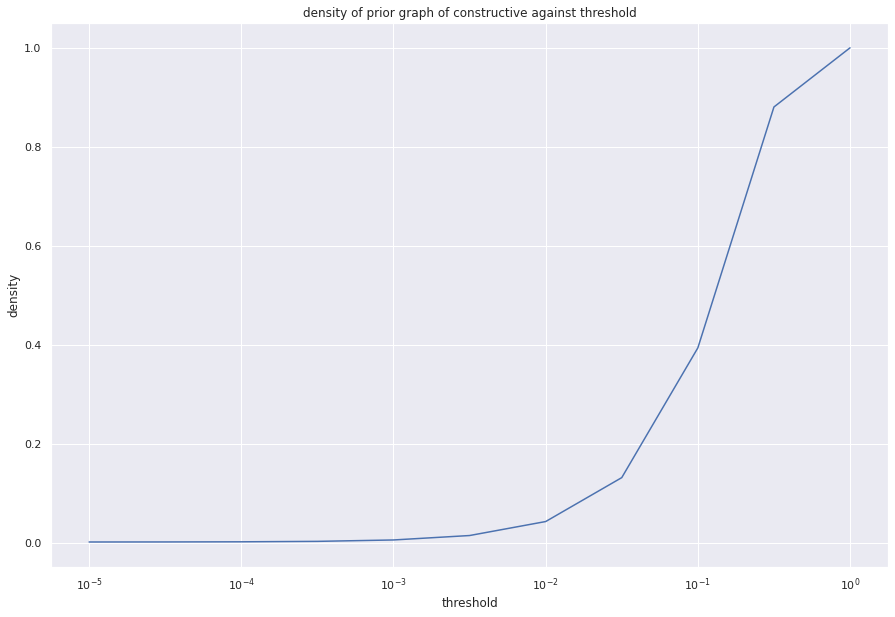

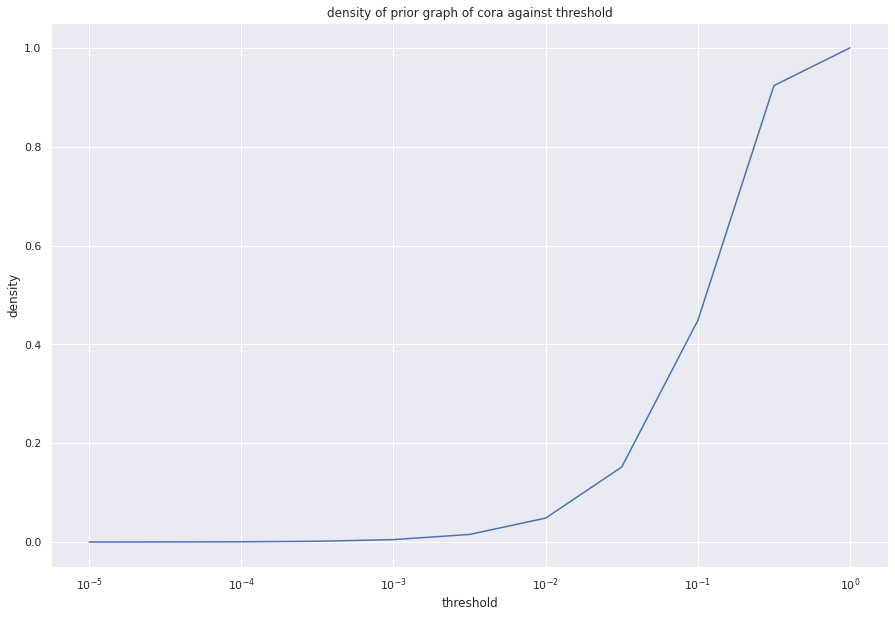

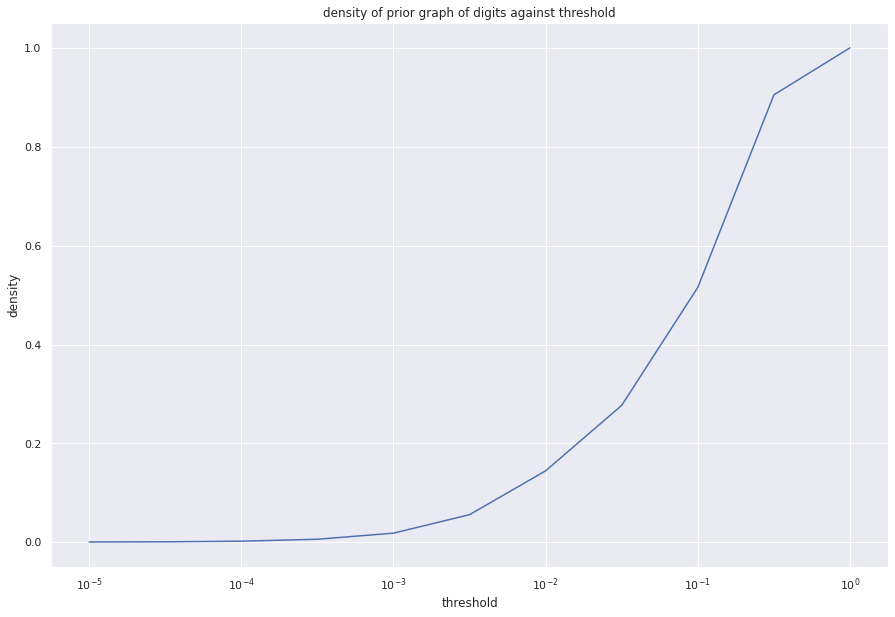

In [0]:
thresholds = np.logspace(-5, 0, num=11)

densities = {}

for data in final_datasets.keys():
  densities[data] = []
  for thr in thresholds:
    print('dataset {}, threshold {}'.format(data, thr))
    actual_dataset = final_datasets[data]
    eij = find_prior_edges_continuous(actual_dataset, thr)
    density = np.sum(eij) / (np.size(eij) * dataset_features[data])
    densities[data].append(density)
  plt.figure(figsize=(15,10))
  plt.semilogx(thresholds, densities[data])
  plt.title('density of prior graph of {} against threshold'.format(data))
  plt.xlabel('threshold')
  plt.ylabel('density')
  plt.savefig('plots/prior_densities/{}'.format(data))

In [0]:
sample_e = find_prior_edges_continuous(final_datasets['constructive'], 0.1)
t1 = time.time()
q_nonvec, _, __, ___ = find_posterior_edges_uniform(sample_e, 500, 0.7, 0.3, 0.5, 0.01)
q_nonvec = np.array(q_nonvec)
t2 = time.time()
q_vec, _, __, ___ = find_posterior_edges_uniform2(sample_e, 500, 0.7, 0.3, 0.5, 0.01)
t3 = time.time()
print("nonvec: {} seconds".format(t2-t1))
print("vec: {} seconds".format(t3-t2))
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
t4 = time.time()
g_nonvec = generate_graph(q_nonvec, 0.9)
t5 = time.time()
g_vec = generate_graph(q_vec, 0.9)
t6 = time.time()
print("nonvec graph: {} seconds".format(t5-t4))
print("vec graph: {} seconds".format(t6-t5))
print((g_nonvec == g_vec).all())
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

nonvec: 70.31299328804016 seconds
vec: 0.3167531490325928 seconds
nonvec graph: 0.3717787265777588 seconds
vec graph: 0.3927888870239258 seconds
True


In [24]:
final_labels = {
    'aminer': aminer_labels,
    'cell': cell_labels,
    'constructive': constructive_labels,
    'cora': cora_labels,
    'digits': digits_labels,
    'fma': fma_labels,
    'segmentation': segmentation_labels
}

for data in final_labels.keys():
  num_truth = len(np.unique(final_labels[data]))
  print("{} dataset has {} ground truth classes".format(data, num_truth))

aminer dataset has 7 ground truth classes
cell dataset has 10 ground truth classes
constructive dataset has 10 ground truth classes
cora dataset has 7 ground truth classes
digits dataset has 10 ground truth classes
fma dataset has 8 ground truth classes
segmentation dataset has 7 ground truth classes


In [0]:
spec_thresholds = {
    'aminer': [0.005, 0.0075, 0.01, 0.0125, 0.015],
    'cell': [0.3, 0.35, 0.4, 0.45, 0.5],
    'constructive': [0.05, 0.1, 0.15, 0.2, 0.25],
    'cora': [0.005, 0.0075, 0.01, 0.0125, 0.015],
    'digits': [0.005, 0.0075, 0.01, 0.0125, 0.015],
    'fma': [0.05, 0.075, 0.1, 0.125, 0.15],
    'segmentation': [0.02, 0.03, 0.04, 0.05, 0.06]
}

accuracies = {}

for data in final_datasets.keys():
  accuracies[data] = []
  thresholds = spec_thresholds[data]
  for thr in thresholds:
    print('dataset {}, threshold {}'.format(data, thr))
    actual_dataset = final_datasets[data]
    eij = find_prior_edges_continuous(actual_dataset, thr)
    if data=='cell' and thr == 0.3:
      print("prior generated")
    q_ij = find_posterior_edges_uniform(eij, dataset_features[data], 0.7, 0.3, 0.5, 0.01)[0]
    if data=='cell' and thr == 0.3:
      print("posterior generated")
    graph = generate_graph(q_ij, 0.9)
    if data=='cell' and thr == 0.3:
      print("graph generated")
    meanacc = measure_accuracy(data, actual_dataset, final_labels[data], adj=graph, model='gcn', num_repeats=1)
    accuracies[data].append(meanacc)
    print("accuracy: {}%".format(100*meanacc))
  mlpacc = measure_accuracy(data, actual_dataset, final_labels[data], adj=graph, model='mlp')
  print("MLP accuracy on {}: {}%".format(data, 100*mlpacc))
  plt.figure(figsize=(15,10))
  plt.plot(thresholds, accuracies[data])
  plt.axhline(mlpacc, color='r', linestyle='--')
  plt.title('accuracy against threshold on {}'.format(data))
  plt.xlabel('threshold')
  plt.ylabel('accuracy')
  plt.savefig('plots/accuracy_vs_thresholds/{}'.format(data))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

dataset cell, threshold 0.3
prior generated
posterior generated
graph generated
accuracy: 54.35287952423096%
dataset cell, threshold 0.35
accuracy: 54.76464629173279%
dataset cell, threshold 0.4
accuracy: 50.117599964141846%
dataset cell, threshold 0.45
accuracy: 49.70583617687225%
dataset cell, threshold 0.5
accuracy: 48.70583415031433%


KeyboardInterrupt: ignored

In [0]:
print(run_gcn("cell", cell_dataset, cell_labels, adj=graph, model='mlp'))
print(run_gcn("cell", final_datasets['cell'], cell_labels, adj=graph, model='mlp'))

0.8547046
0.80294


In [0]:
adjacency = generate_graph(qij[0], 0.9)
print(adjacency.sum() / (2485 * 2484))

0.20273039201391926


# AMINER

0.01, 0.9

MLP: 44.9%

GCN: 45.1%

In [0]:
ami_d = final_datasets['aminer']
ami_l = final_labels['aminer']
ami_P = dataset_features['aminer']

ami_thresh = 0.01
ami_cut = 0.9

ami_prior = find_prior_edges_continuous(ami_d, ami_thresh)
ami_posterior, ami_alpha, ami_beta, ami_rho = find_posterior_edges_uniform(ami_prior, ami_P, 0.7, 0.3, 0.5, 0.01)
ami_adj = generate_graph(ami_posterior, ami_cut)

aminer_mlp = measure_accuracy('aminer', ami_d, ami_l, adj=ami_adj, model='mlp', num_repeats=5, verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: overflow encountered in exp


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

iteration took 32.78282427787781 seconds
iteration took 23.948819160461426 seconds
iteration took 23.89129376411438 seconds
iteration took 23.715081930160522 seconds
iteration took 23.90541982650757 seconds


In [0]:
ami_d = final_datasets['aminer']
ami_l = final_labels['aminer']
ami_P = dataset_features['aminer']

ami_thresh = 0.01
ami_cut = 0.9

ami_prior = find_prior_edges_continuous(ami_d, ami_thresh)
ami_posterior, ami_alpha, ami_beta, ami_rho = find_posterior_edges_uniform(ami_prior, ami_P, 0.7, 0.3, 0.5, 0.01)
ami_adj = generate_graph(ami_posterior, ami_cut)

aminer_gcn = measure_accuracy('aminer', ami_d, ami_l, adj=ami_adj, model='gcn', num_repeats=5, verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: overflow encountered in exp


iteration took 23.93363881111145 seconds
iteration took 23.804521799087524 seconds
iteration took 23.67438530921936 seconds
iteration took 23.749125957489014 seconds
iteration took 23.692911386489868 seconds


# CELL

In [0]:
cell_d = final_datasets['cell']
cell_l = final_labels['cell']
cell_P = dataset_features['cell']

cell_thresh = 0.01
cell_cut = 0.9

cell_prior = find_prior_edges_continuous(cell_d, cell_thresh)
cell_posterior, cell_alpha, cell_beta, cell_rho = find_posterior_edges_uniform(cell_prior, cell_P, 0.7, 0.3, 0.5, 0.01)
cell_adj = generate_graph(cell_posterior, cell_cut)

cell_mlp = measure_accuracy('cell', cell_d, cell_l, adj=cell_adj, model='mlp', num_repeats=5, verbose=True)

iteration took 141.8265025615692 seconds
iteration took 145.26581573486328 seconds
iteration took 150.87275075912476 seconds
iteration took 134.63348937034607 seconds
iteration took 159.57027554512024 seconds


In [0]:
cell_d = final_datasets['cell']
cell_l = final_labels['cell']
cell_P = dataset_features['cell']

# 0.01, 0.9: 37.9
# 0.05, 0.9: 47.3, 44
# 0.1, 0.9: 28 ish
# 0.1, 0.05: 40.1
cell_thresh = 0.05
cell_cut = 0.92

cell_prior = find_prior_edges_continuous(cell_d, cell_thresh)
cell_posterior, cell_alpha, cell_beta, cell_rho = find_posterior_edges_uniform(cell_prior, cell_P, 0.7, 0.3, 0.5, 0.01)
cell_adj = generate_graph(cell_posterior, cell_cut)

cell_gcn = measure_accuracy('cell', cell_d, cell_l, adj=cell_adj, model='gcn', num_repeats=5, verbose=True)

iteration took 176.37851214408875 seconds
iteration took 199.9270360469818 seconds
iteration took 141.70827722549438 seconds
iteration took 174.60485243797302 seconds
iteration took 186.12857127189636 seconds


# CONSTRUCTIVE

In [0]:
con_d = final_datasets['constructive']
con_l = final_labels['constructive']
con_P = dataset_features['constructive']

con_thresh = 0.1
con_cut = 0.9

con_prior = find_prior_edges_continuous(con_d, con_thresh)
con_posterior, con_alpha, con_beta, con_rho = find_posterior_edges_uniform(con_prior, con_P, 0.7, 0.3, 0.5, 0.01)
con_adj = generate_graph(con_posterior, con_cut)

constructive_mlp = measure_accuracy('constructive', con_d, con_l, adj=con_adj, model='mlp', num_repeats=5, verbose=True)

iteration took 12.666256666183472 seconds
iteration took 12.816761255264282 seconds
iteration took 12.872092962265015 seconds
iteration took 13.15876317024231 seconds
iteration took 13.150044441223145 seconds


In [0]:
con_d = final_datasets['constructive']
con_l = final_labels['constructive']
con_P = dataset_features['constructive']

# 0.1, 0.9: 10.12
# 0.12, 0.9: 10.08
# 0.08, 0.9: 11.53
# 0.07, 0.9: 10.59
# 0.08, 0.99: 14.63
# 0.08, 0.999: 23.53
con_thresh = 0.08
con_cut = 0.999

con_prior = find_prior_edges_continuous(con_d, con_thresh)
con_posterior, con_alpha, con_beta, con_rho = find_posterior_edges_uniform(con_prior, con_P, 0.7, 0.3, 0.5, 0.01)
con_adj = generate_graph(con_posterior, con_cut)

constructive_gcn = measure_accuracy('constructive', con_d, con_l, adj=con_adj, model='gcn', num_repeats=5, verbose=True)

iteration took 12.444000482559204 seconds
iteration took 12.43949556350708 seconds
iteration took 12.675650596618652 seconds
iteration took 12.879041194915771 seconds
iteration took 12.771530866622925 seconds


# CORA

In [0]:
cor_d = final_datasets['cora']
cor_l = final_labels['cora']
cor_P = dataset_features['cora']

cor_thresh = 0.01
cor_cut = 0.9

cor_prior = find_prior_edges_continuous(cor_d, cor_thresh)
cor_posterior, cor_alpha, cor_beta, cor_rho = find_posterior_edges_uniform(cor_prior, cor_P, 0.7, 0.3, 0.5, 0.01)
cor_adj = generate_graph(cor_posterior, cor_cut)

cora_mlp = measure_accuracy('cora', cor_d, cor_l, adj=cor_adj, model='mlp', num_repeats=5, verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: overflow encountered in exp


iteration took 75.77608275413513 seconds
iteration took 76.1659038066864 seconds
iteration took 76.5118510723114 seconds
iteration took 76.39043045043945 seconds
iteration took 76.9776029586792 seconds


In [0]:
cor_d = final_datasets['cora']
cor_l = final_labels['cora']
cor_P = dataset_features['cora']

# 0.01, 0.9: 48.37
# 0.02, 0.9: 5.11
# 0.01, 0.99: 46.90
cor_thresh = 0.01
cor_cut = 0.9

cor_prior = find_prior_edges_continuous(cor_d, cor_thresh)
cor_posterior, cor_alpha, cor_beta, cor_rho = find_posterior_edges_uniform(cor_prior, cor_P, 0.7, 0.3, 0.5, 0.01)
cor_adj = generate_graph(cor_posterior, cor_cut)

cora_gcn = measure_accuracy('cora', cor_d, cor_l, adj=cor_adj, model='gcn', num_repeats=5, verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: overflow encountered in exp


iteration took 78.20008254051208 seconds
iteration took 77.70812940597534 seconds
iteration took 78.40207195281982 seconds
iteration took 77.52010178565979 seconds
iteration took 78.5501275062561 seconds


# DIGITS

In [0]:
dig_d = final_datasets['digits']
dig_l = final_labels['digits']
dig_P = dataset_features['digits']

dig_thresh = 0.01
dig_cut = 0.9

dig_prior = find_prior_edges_continuous(dig_d, dig_thresh)
dig_posterior, dig_alpha, dig_beta, dig_rho = find_posterior_edges_uniform(dig_prior, dig_P, 0.7, 0.3, 0.5, 0.01)
dig_adj = generate_graph(dig_posterior, dig_cut)

digits_mlp = measure_accuracy('digits', dig_d, dig_l, adj=dig_adj, model='mlp', num_repeats=5, verbose=True)

iteration took 15.64833688735962 seconds
iteration took 20.279865026474 seconds
iteration took 25.479551792144775 seconds
iteration took 23.02925395965576 seconds
iteration took 19.850674390792847 seconds


In [0]:
dig_d = final_datasets['digits']
dig_l = final_labels['digits']
dig_P = dataset_features['digits']

# 0.01, 0.9: 80.30
# 0.008, 0.9: 78.53
# 0.012, 0.9: 79.something
# 0.011, 0.9: 80.14
# 0.011, 0.99: 
dig_thresh = 0.011
dig_cut = 0.99

dig_prior = find_prior_edges_continuous(dig_d, dig_thresh)
dig_posterior, dig_alpha, dig_beta, dig_rho = find_posterior_edges_uniform(dig_prior, dig_P, 0.7, 0.3, 0.5, 0.01)
dig_adj = generate_graph(dig_posterior, dig_cut)

digits_gcn = measure_accuracy('digits', dig_d, dig_l, adj=dig_adj, model='gcn', num_repeats=5, verbose=True)

iteration took 18.74279522895813 seconds
iteration took 27.32289171218872 seconds
iteration took 20.590981006622314 seconds
iteration took 16.009345531463623 seconds
iteration took 18.814702033996582 seconds


# FMA

In [0]:
fma_d = final_datasets['fma']
fma_l = final_labels['fma']
fma_P = dataset_features['fma']

fma_thresh = 0.1
fma_cut = 0.9

fma_prior = find_prior_edges_continuous(fma_d, fma_thresh)
fma_posterior, fma_alpha, fma_beta, fma_rho = find_posterior_edges_uniform(fma_prior, fma_P, 0.7, 0.3, 0.5, 0.01)
fma_adj = generate_graph(fma_posterior, fma_cut)

fma_mlp = measure_accuracy('fma', fma_d, fma_l, adj=fma_adj, model='mlp', num_repeats=5, verbose=True)

iteration took 184.79768133163452 seconds
iteration took 193.358806848526 seconds
iteration took 149.60090231895447 seconds
iteration took 198.31392788887024 seconds
iteration took 179.7914435863495 seconds


In [0]:
fma_d = final_datasets['fma']
fma_l = final_labels['fma']
fma_P = dataset_features['fma']

# 0.1, 0.9: 29.96
# 0.12, 0.9: 30.20
# 0.12, 0.99: 30.88
# 0.12, 0.999: 30.94
fma_thresh = 0.13
fma_cut = 0.999

fma_prior = find_prior_edges_continuous(fma_d, fma_thresh)
fma_posterior, fma_alpha, fma_beta, fma_rho = find_posterior_edges_uniform(fma_prior, fma_P, 0.7, 0.3, 0.5, 0.01)
fma_adj = generate_graph(fma_posterior, fma_cut)

fma_gcn = measure_accuracy('fma', fma_d, fma_l, adj=fma_adj, model='gcn', num_repeats=5, verbose=True)

iteration took 146.76665925979614 seconds
iteration took 153.32884311676025 seconds
iteration took 132.39835906028748 seconds
iteration took 160.75756978988647 seconds
iteration took 116.64708018302917 seconds


# SEGMENTATION

In [0]:
seg_d = final_datasets['segmentation']
seg_l = final_labels['segmentation']
seg_P = dataset_features['segmentation']

seg_thresh = 0.05
seg_cut = 0.9

seg_prior = find_prior_edges_continuous(seg_d, seg_thresh)
seg_posterior, seg_alpha, seg_beta, seg_rho = find_posterior_edges_uniform(seg_prior, seg_P, 0.7, 0.3, 0.5, 0.01)
seg_adj = generate_graph(seg_posterior, seg_cut)

seg_mlp = measure_accuracy('segmentation', seg_d, seg_l, adj=seg_adj, model='mlp', num_repeats=5, verbose=True)

iteration took 16.887953281402588 seconds
iteration took 16.910874843597412 seconds
iteration took 18.33930802345276 seconds
iteration took 23.75775718688965 seconds
iteration took 21.337100744247437 seconds


In [0]:
seg_d = final_datasets['segmentation']
seg_l = final_labels['segmentation']
seg_P = dataset_features['segmentation']

# 0.05, 0.9: 75.10
# 0.04, 0.9: 79.74
# 0.03, 0.9: 84.45
# 0.02, 0.9: 86.59
# 0.022, 0.9: 87.54
seg_thresh = 0.022
seg_cut = 0.9

seg_prior = find_prior_edges_continuous(seg_d, seg_thresh)
seg_posterior, seg_alpha, seg_beta, seg_rho = find_posterior_edges_uniform(seg_prior, seg_P, 0.7, 0.3, 0.5, 0.01)
seg_adj = generate_graph(seg_posterior, seg_cut)

seg_gcn = measure_accuracy('segmentation', seg_d, seg_l, adj=seg_adj, model='gcn', num_repeats=5, verbose=True)

iteration took 16.089199781417847 seconds
iteration took 14.47618317604065 seconds
iteration took 19.92906641960144 seconds
iteration took 15.386167287826538 seconds
iteration took 17.15960192680359 seconds


# Accuracies

In [0]:
print("AMINER MLP ACCURACY: {}".format(aminer_mlp))
print("AMINER GCN ACCURACY: {}".format(aminer_gcn))
print()
print("CELL MLP ACCURACY: {}".format(cell_mlp))
print("CELL GCN ACCURACY: {}".format(cell_gcn))
print()
print("CONSTRUCTIVE MLP ACCURACY: {}".format(constructive_mlp))
print("CONSTRUCTIVE GCN ACCURACY: {}".format(constructive_gcn))
print()
print("CORA MLP ACCURACY: {}".format(cora_mlp))
print("CORA GCN ACCURACY: {}".format(cora_gcn))
print()
print("DIGITS MLP ACCURACY: {}".format(digits_mlp))
print("DIGITS GCN ACCURACY: {}".format(digits_gcn))
print()
print("FMA MLP ACCURACY: {}".format(fma_mlp))
print("FMA GCN ACCURACY: {}".format(fma_gcn))
print()
print("SEGMENTATION MLP ACCURACY: {}".format(seg_mlp))
print("SEGMENTATION GCN ACCURACY: {}".format(seg_gcn))

AMINER MLP ACCURACY: 0.41748014092445374
AMINER GCN ACCURACY: 0.45017027854919434

CELL MLP ACCURACY: 0.36494114995002747
CELL GCN ACCURACY: 0.47011762857437134

CONSTRUCTIVE MLP ACCURACY: 0.10282353311777115
CONSTRUCTIVE GCN ACCURACY: 0.2181176245212555

CORA MLP ACCURACY: 0.47401800751686096
CORA GCN ACCURACY: 0.4747752249240875

DIGITS MLP ACCURACY: 0.8006545305252075
DIGITS GCN ACCURACY: 0.7920156717300415

FMA MLP ACCURACY: 0.2974117696285248
FMA GCN ACCURACY: 0.31164705753326416

SEGMENTATION MLP ACCURACY: 0.7516293525695801
SEGMENTATION GCN ACCURACY: 0.8738288879394531


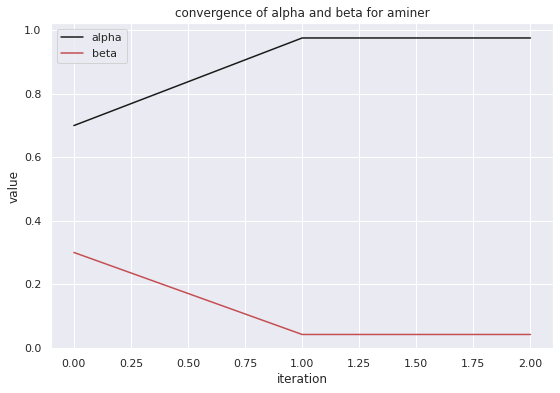

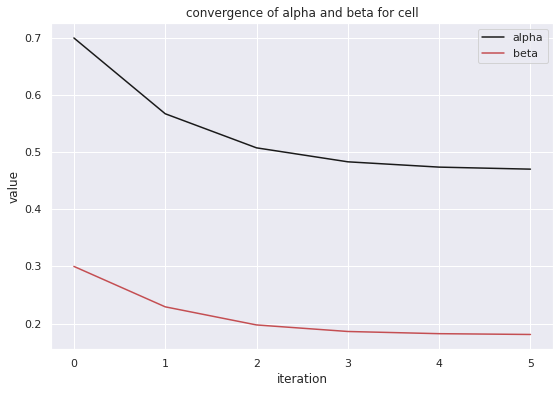

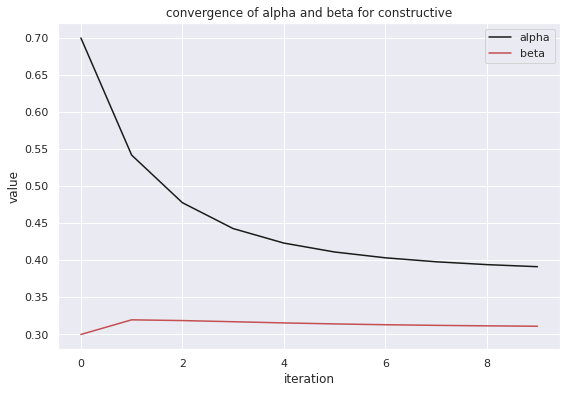

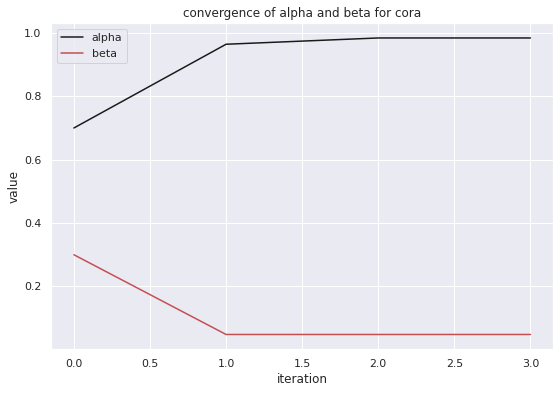

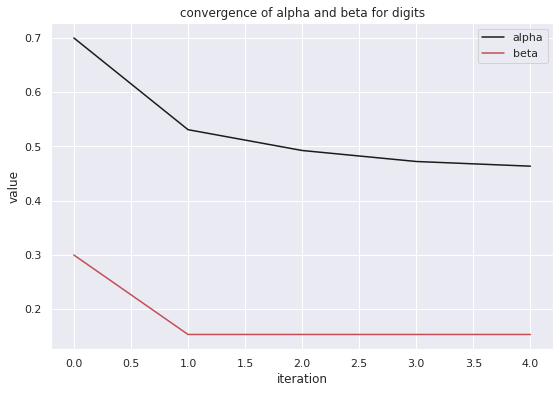

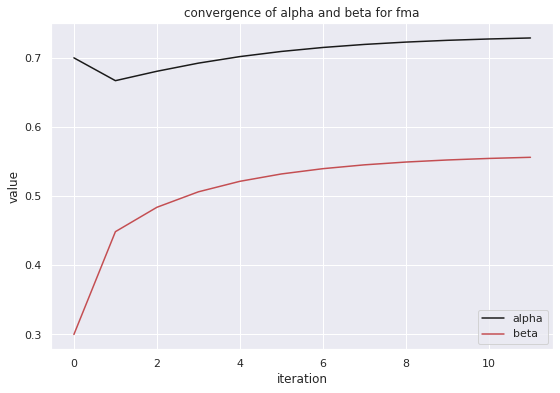

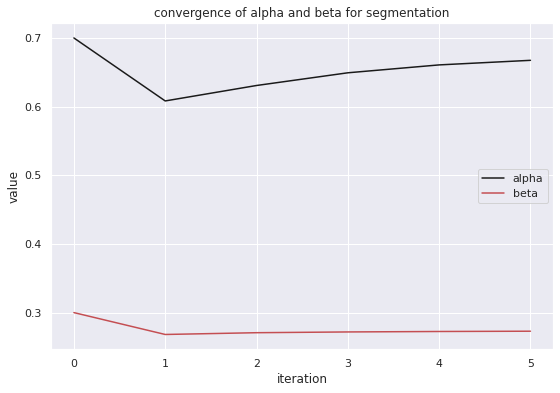

In [0]:
plt.figure(figsize=(9,6))
plt.plot(ami_alpha, 'k')
plt.plot(ami_beta, 'r')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('convergence of alpha and beta for aminer')
plt.legend(['alpha', 'beta'])
plt.savefig('plots/alphabeta/aminer')

plt.figure(figsize=(9,6))
plt.plot(cell_alpha, 'k')
plt.plot(cell_beta, 'r')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('convergence of alpha and beta for cell')
plt.legend(['alpha', 'beta'])
plt.savefig('plots/alphabeta/cell')

plt.figure(figsize=(9,6))
plt.plot(con_alpha, 'k')
plt.plot(con_beta, 'r')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('convergence of alpha and beta for constructive')
plt.legend(['alpha', 'beta'])
plt.savefig('plots/alphabeta/constructive')

plt.figure(figsize=(9,6))
plt.plot(cor_alpha, 'k')
plt.plot(cor_beta, 'r')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('convergence of alpha and beta for cora')
plt.legend(['alpha', 'beta'])
plt.savefig('plots/alphabeta/cora')

plt.figure(figsize=(9,6))
plt.plot(dig_alpha, 'k')
plt.plot(dig_beta, 'r')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('convergence of alpha and beta for digits')
plt.legend(['alpha', 'beta'])
plt.savefig('plots/alphabeta/digits')

plt.figure(figsize=(9,6))
plt.plot(fma_alpha, 'k')
plt.plot(fma_beta, 'r')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('convergence of alpha and beta for fma')
plt.legend(['alpha', 'beta'])
plt.savefig('plots/alphabeta/fma')

plt.figure(figsize=(9,6))
plt.plot(seg_alpha, 'k')
plt.plot(seg_beta, 'r')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('convergence of alpha and beta for segmentation')
plt.legend(['alpha', 'beta'])
plt.savefig('plots/alphabeta/segmentation')

In [0]:
print("final alpha aminer: {}".format(ami_alpha[-1]))
print("final beta aminer: {}".format(ami_beta[-1]))
N = len(ami_adj)
ami_density = np.sum(ami_adj) * (1 / (N * (N - 1)))
print("final density aminer: {}".format(ami_density))

print("final alpha cell: {}".format(cell_alpha[-1]))
print("final beta cell: {}".format(cell_beta[-1]))
N = len(cell_adj)
cell_density = np.sum(cell_adj) * (1 / (N * (N - 1)))
print("final density cell: {}".format(cell_density))

print("final alpha constructive: {}".format(con_alpha[-1]))
print("final beta constructive: {}".format(con_beta[-1]))
N = len(con_adj)
con_density = np.sum(con_adj) * (1 / (N * (N - 1)))
print("final density constructive: {}".format(con_density))

print("final alpha cora: {}".format(cor_alpha[-1]))
print("final beta cora: {}".format(cor_beta[-1]))
N = len(cor_adj)
cor_density = np.sum(cor_adj) * (1 / (N * (N - 1)))
print("final density cora: {}".format(cor_density))

print("final alpha digits: {}".format(dig_alpha[-1]))
print("final beta digits: {}".format(dig_beta[-1]))
N = len(dig_adj)
dig_density = np.sum(dig_adj) * (1 / (N * (N - 1)))
print("final density digits: {}".format(dig_density))

print("final alpha fma: {}".format(fma_alpha[-1]))
print("final beta fma: {}".format(fma_beta[-1]))
N = len(fma_adj)
fma_density = np.sum(fma_adj) * (1 / (N * (N - 1)))
print("final density fma: {}".format(fma_density))

print("final alpha segmentation: {}".format(seg_alpha[-1]))
print("final beta segmentation: {}".format(seg_beta[-1]))
N = len(seg_adj)
seg_density = np.sum(seg_adj) * (1 / (N * (N - 1)))
print("final density segmentation: {}".format(seg_density))

final alpha aminer: 0.9761333333333333
final beta aminer: 0.04144998767210694
final density aminer: 6.9911948231600575e-06
final alpha cell: 0.4702889304592384
final beta cell: 0.18081020027438666
final density cell: 0.2993486743371686
final alpha constructive: 0.39143502281724835
final beta constructive: 0.31111650475832053
final density constructive: 0.029195195195195194
final alpha cora: 0.9840407779362238
final beta cora: 0.04841890071343997
final density cora: 7.452120128176467e-06
final alpha digits: 0.46372163856599113
final beta digits: 0.1536059740653801
final density digits: 6.196915671132164e-07
final alpha fma: 0.728745502313765
final beta fma: 0.5561959083654494
final density fma: 0.29039019509754876
final alpha segmentation: 0.6674343746847005
final beta segmentation: 0.2728965904601005
final density segmentation: 0.01915298502565718


In [0]:
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')